##  <span style='color:Blue'> Web Scrap Nifty latest option from the NSE Website and create bar plots

1. User defined ExpiryDate
2. User defined ATM  (at the money strike)
3. User defined interval (will be used in calculating of spreads later on)
3. User defined UpRange
4. User defined DownRange

In [1]:
import datetime
ExpiryDate = datetime.datetime(2022,7,28)

ATM = 16600
Interval = 200
UpRange = ATM + 500
DownRange = ATM - 500

The next 4 steps are to create a request object and store the results in dataframe called Options_LargeDataFrame

In [2]:
import requests
import json
import pandas as pd
from requests.auth import HTTPBasicAuth

url = 'https://www.nseindia.com/api/option-chain-indices?symbol=NIFTY'

headers = {'User-Agent': 'Mozilla/5.0'}

page = requests.get(url,headers=headers,auth=HTTPBasicAuth('user', 'pass'))


In [3]:
dajs = page.json()


In [4]:
Options = dajs['records']['data']
Timestamp = dajs['records']['timestamp']


In [5]:
Options_LargeDataFrame = pd.json_normalize(Options)
Options_LargeDataFrame['expiryDate'] = pd.to_datetime(Options_LargeDataFrame['expiryDate'])

Options_LargeDataFrame['Timestamp'] = Timestamp
Options_LargeDataFrame['Timestamp'] = pd.to_datetime(Options_LargeDataFrame['Timestamp'])

Create a subset dataframe Options_SmallDataFrame from Options_LargeDataFrame

In [6]:
  
Options_SmallDataFrame =    Options_LargeDataFrame[['strikePrice','expiryDate','PE.openInterest','PE.changeinOpenInterest','PE.lastPrice','PE.impliedVolatility','CE.openInterest','CE.changeinOpenInterest','CE.lastPrice','CE.impliedVolatility','CE.underlyingValue','Timestamp']]
Options_SmallDataFrame =  Options_SmallDataFrame[(Options_SmallDataFrame['expiryDate'] == ExpiryDate) & (Options_SmallDataFrame['strikePrice'] >= DownRange) & (Options_SmallDataFrame['strikePrice'] <= UpRange) ] 


Plot open interest of calls and puts

<AxesSubplot:title={'center':'Open Interest Chg  25-Jul-2022 15:30:00'}, xlabel='strikePrice'>

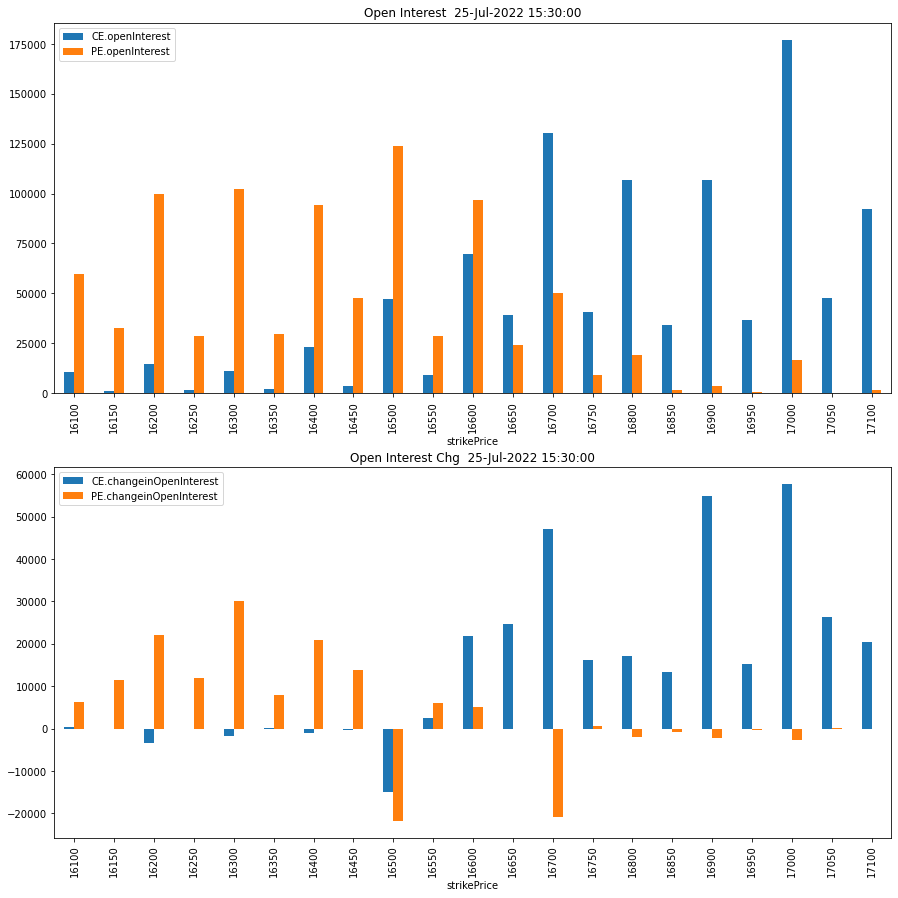

In [7]:
import matplotlib.pyplot as plt
figure, ax = plt.subplots(2, 1)

Options_SmallDataFrame.plot.bar(x = 'strikePrice', y = ['CE.openInterest','PE.openInterest'] , ax = ax[0] , figsize=(15,15) , title = 'Open Interest' + '  ' + Timestamp)
Options_SmallDataFrame.plot.bar(x = 'strikePrice', y = ['CE.changeinOpenInterest','PE.changeinOpenInterest'],ax = ax[1], figsize=(15,15), title = 'Open Interest Chg' + '  ' + Timestamp)


Calculate metrics:
1. PCR (Put Call Ratio)
2. ATM Premium (At the money premium)
3. OTM Premium (Out of the money premium)
4. Bull Call Spread
5. Bear Put Spread
6. Bull Call Butterfly Spread
7. Bear Put Butterfly Spread

In [8]:
print('PCR' + ' ' + str(round(sum(Options_SmallDataFrame['PE.openInterest'])/sum(Options_SmallDataFrame['CE.openInterest']),2)))

PCR 0.87


In [9]:
#ATM Premium
float(Options_SmallDataFrame.loc[Options_SmallDataFrame.strikePrice == ATM,'PE.lastPrice'] 
      + Options_SmallDataFrame.loc[Options_SmallDataFrame.strikePrice == ATM,'CE.lastPrice'])

206.9

In [10]:
#OTM PRemium
OTMPremium = float(Options_SmallDataFrame.loc[Options_SmallDataFrame.strikePrice == ATM - Interval,'PE.lastPrice']) + float(Options_SmallDataFrame.loc[Options_SmallDataFrame.strikePrice == ATM + Interval,'CE.lastPrice'])
OTMPremium

68.25

In [11]:
#BullCall Spread
x =float(Options_SmallDataFrame.loc[Options_SmallDataFrame.strikePrice == ATM,'CE.lastPrice'])
y = float(Options_SmallDataFrame.loc[Options_SmallDataFrame.strikePrice == ATM + Interval ,'CE.lastPrice'])
x - y

75.75

In [12]:
#Bear Put Spread
x =float(Options_SmallDataFrame.loc[Options_SmallDataFrame.strikePrice == ATM,'PE.lastPrice'])
y = float(Options_SmallDataFrame.loc[Options_SmallDataFrame.strikePrice == ATM - Interval ,'PE.lastPrice'])
x - y

62.900000000000006

In [13]:
# Bull Call Butterfly Spread
x =float(Options_SmallDataFrame.loc[Options_SmallDataFrame.strikePrice == ATM,'CE.lastPrice'])
y =float(Options_SmallDataFrame.loc[Options_SmallDataFrame.strikePrice == ATM + Interval,'CE.lastPrice']) *2
z = float(Options_SmallDataFrame.loc[Options_SmallDataFrame.strikePrice == ATM + Interval*2,'CE.lastPrice'])

x - y + z


47.75

In [14]:
#Bear Put Butterfly Spread
x =float(Options_SmallDataFrame.loc[Options_SmallDataFrame.strikePrice == ATM,'PE.lastPrice'])
y =float(Options_SmallDataFrame.loc[Options_SmallDataFrame.strikePrice == ATM - Interval,'PE.lastPrice']) *2
z = float(Options_SmallDataFrame.loc[Options_SmallDataFrame.strikePrice == ATM - Interval*2,'PE.lastPrice'])

x - y + z


40.35000000000001